## Group 3:
Classes: 3, 1, 4, 6, 8
    
    Open Country - 3
    Tall Building - 1
    Mountain - 4
    Highway - 6
    Coast - 8


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from io import StringIO
import pdb
from math import sqrt, log
from sklearn.metrics import accuracy_score, f1_score, precision_score

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.data = []
        self.filename = filename
        tar = tarfile.open(folder + '/' + filename)
        for file in tar.getmembers():
            f = tar.extractfile(file)
            if f != None:
                content = pd.read_csv(StringIO(f.read().decode()), sep=' ', header=None).values.ravel()
                self.data.append(content)
            
        self.y = torch.tensor(label_dict[self.filename[:-7]], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [5]:
def train_test_loader(directory, label_dict, train_fraction=0.8, num_workers=2, bs_fraction = 0.2):

    all_files = list(filter(lambda x: x.endswith('.tar.gz'), os.listdir(directory)))
    files = [file for file in all_files if file[:-7] in label_dict.keys()]
    
    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=int(bs_fraction*N), shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=int(bs_fraction*N), shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader

In [6]:
class GBRBM:
    
    def __init__(self, visible_nodes, h_len, lr_W=0.1, lr_bias=0.001):  
        # set lower lr for bias than for the weights
        self.N = visible_nodes.shape[0]
        v_len = visible_nodes.shape[1]
        self.V = visible_nodes.to(device)
        self.sigma2 = torch.var(self.V, 0)[0].to(device)  
        self.lr_W = lr_W
        self.lr_bias = lr_bias
        
        # Initialisation done based on the methods mentioned in the paper
        self.W = torch.empty(v_len, h_len).uniform_(-sqrt(6/(v_len+h_len)), sqrt(6/(v_len+h_len))).to(device)
        self.b = torch.mean(visible_nodes, axis=0).view(1,-1).to(device)
        self.c = torch.tensor([((torch.norm(self.b + self.W[:, i])**2 - torch.norm(self.b)**2)/(2*self.sigma2) +  log(0.01)).item() for i in range(h_len)]).view(1,-1).to(device)

    def get_h(self, v):
        
        a = torch.mm((v/self.sigma2).view(1,-1), self.W) + self.c
        f = torch.nn.Sigmoid()
        p_h_v = f(a)
        return p_h_v, torch.bernoulli(p_h_v)
    
    def get_v(self, h):
        a = torch.mm(h.view(1,-1), self.W.T) + self.b # mean of normal dist
        if (torch.isnan(a)).any().item():
            pdb.set_trace()
        else:
            pass
        v_h = torch.normal(mean=a, std=torch.sqrt(self.sigma2)).to(device)
        return v_h
    
    def params_update(self, p_h_v0, p_h_vk, v0, vk):
        self.W += self.lr_W*(torch.mm((v0/self.sigma2).view(-1,1), p_h_v0) - torch.mm((vk/self.sigma2).view(-1,1), p_h_vk))/self.N
        self.b += self.lr_bias*(v0 - vk)/self.N
        self.c += self.lr_bias*(p_h_v0 - p_h_vk)/self.N

        
    def one_epoch(self, k):
        for v0 in self.V:
            v_t = v0
            for t in range(k):  
                p_h_vt, h_t = self.get_h(v_t)
                if t==0:
                    p_h_v0 = p_h_vt                    
                v_t1 = self.get_v(h_t)
                v_t = v_t1

            try:
                V_k = torch.cat((V_k, v_t.view(1,-1)), dim=0)
                H_k = torch.cat((H_k, h_t.view(1,-1)), dim=0)
            except:
                V_k = v_t.view(1,-1)
                H_k = h_t.view(1,-1)
            self.params_update(p_h_v0, p_h_vt, v0, v_t)
        return V_k, H_k
        
    def train(self, k):
        ep = 0
        error_old = np.inf
        max_ep = 100
        while True: #ep<=max_ep:
            ep += 1
            ## Check if error should be SSE?
            V_k, H_k = self.one_epoch(k)

            error_new = torch.sum((V_k - self.V)**2) 
            error_new = error_new/V_k.shape[0]
            print('Epoch: {0}, Error: {1}, Error diff :{2}'.format(ep, error_new, abs((error_old-error_new)/error_new)))
            
            if abs(error_new - error_old)/error_new <= 1e-3:
                print('Converged!')
                break
            error_old = error_new

        self.V_train = V_k
        self.H_train = H_k      


In [7]:
class BBRBM:
    
    def __init__(self, visible_nodes, h_len, lr_W=0.01, lr_bias=0.001):
        
        # set lower lr for bias than for the weights
        
        self.N = visible_nodes.shape[0]        
        v_len = visible_nodes.shape[1]
        self.W = torch.randn(v_len, h_len).to(device)
        self.b = torch.randn(1, v_len).to(device)
        self.c = torch.randn(1, h_len).to(device)
        self.V = visible_nodes.to(device)
        self.lr_W = lr_W
        self.lr_bias = lr_bias        
        
    def get_h(self, v):
        
        a = torch.mm(v.view(1,-1), self.W) + self.c
        f = torch.nn.Sigmoid()
        p_h_v = f(a)
        return p_h_v, torch.bernoulli(p_h_v)
    
    def get_v(self, h):
        a = torch.mm(h.view(1,-1), self.W.T) + self.b
        f = torch.nn.Sigmoid()
        p_v_h = f(a)
        return p_v_h, torch.bernoulli(p_v_h)
    
    def params_update(self, p_h_v0, p_h_vk, v0, vk):
        self.W += self.lr_W*(torch.mm(v0.view(-1,1), p_h_v0) - torch.mm(vk.view(-1,1), p_h_vk))/self.N
        self.b += self.lr_bias*(v0 - vk)/self.N
        self.c += self.lr_bias*(p_h_v0 - p_h_vk)/self.N
        
    def one_epoch(self, k):

        for v0 in self.V:
            v_t = v0
            for t in range(k):  
                p_h_vt, h_t = self.get_h(v_t)
                if t==0:
                    p_h_v0 = p_h_vt                    
                p_v_ht, v_t1 = self.get_v(h_t)
                v_t = v_t1

            try:
                V_k = torch.cat((V_k, v_t.view(1,-1)), dim=0)
                H_k = torch.cat((H_k, h_t.view(1,-1)), dim=0)
            except:
                V_k = v_t.view(1,-1)
                H_k = h_t.view(1,-1)

            self.params_update(p_h_v0, p_h_vt, v0, v_t)

        return V_k, H_k
        
    def train(self, k):
        ep = 0
        error_old = np.inf

        max_ep = 100
        while True: #ep <= max_ep:
            ep += 1
            ## Check if error should be SSE?
            V_k, H_k = self.one_epoch(k)
            error_new = torch.sum((V_k - self.V)**2) 
            error_new = error_new/V_k.shape[0]
            print('Epoch: {0}, Error: {1}, Error diff :{2}'.format(ep, error_new, abs((error_old-error_new)/error_new)))
            
            if abs(error_new - error_old)/error_new <= 1e-3:
                print('Converged!')               
                break
            error_old = error_new
        self.V_train = V_k
        self.H_train = H_k 

In [8]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.out = nn.Linear(hidden_sizes[2], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred   

In [9]:
def Gaussian_stacked_RBM(v, n_stacks, h_layers_len, learning_rates, k_list):
    '''
    Parameters:
    ------------
    v              - Input to RBM (visible nodes). Must be continuous valued, whitened.
    n_stacks       - No. of RMBs to be stacked
    h_layers_len   - List of no. of nodes in the hidden layer of each RMB
    learning_rates - List of list of learning rates (for Weights, bias) for each RBM
    k_list         - List of k values for each RBM
     '''
    
    weights = []
    biases = []
    
    print('------Gaussian Binary RBM------')
    gaussain = GBRBM(v_whitened.to(device), h_layers_len[0], learning_rates[0][0], learning_rates[0][1])
    gaussain.train(k_list[0])
    weights.append(gaussain.W)
    biases.append(gaussain.c)
    v_new = gaussain.H_train
    
    for i in range(1, n_stacks):
        print('------Binary Binary RBM {0}------'.format(i))
        binary = BBRBM(v_new.to(device), h_layers_len[i], learning_rates[i][0], learning_rates[i][1])
        binary.train(k_list[i])
        weights.append(binary.W)
        biases.append(binary.c)
        v_new = binary.H_train
        
    return weights, biases

1. Finding $\sigma^{2}$ for visible nodes
2. Whitening of data for GBRMB?
3. Choice of initial conditions



### Data pre-processing - Whitening the images

In [10]:

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
# label_dict = {
#     'tallbuilding': 1,
#     'mountain': 4,
#     'highway': 6,
#     'coast': 8,
#     'opencountry' : 3    
# }


label_dict = {
    'tallbuilding': 0,
    'mountain': 1,
    'highway': 2,
    'coast': 3, 
    'opencountry': 4}

trainloader, testloader = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0, bs_fraction = 1)

In [12]:
v = list(trainloader)[0][0]
v_centered = v - torch.stack([torch.mean(v, 0)]*v.shape[0], dim=0)
cov = torch.mm(v_centered.T, v_centered)/v_centered.shape[0]
U, S, V = torch.svd(cov)
v_whitened = torch.mm(v_centered, U)/torch.sqrt(S)

In [13]:
v.shape

torch.Size([1408, 828])

PCA:
FinalNet(reduced_dimension, [150, 75, 50], 5)

In [ ]:
# gaussian = GBRBM(v_whitened.to(device), 150, 0.001, 0.01)
# gaussian.train(100)

In [14]:
n_stacks = 3
h_layers_len = [150, 75, 50]
learning_rates = [[0.001, 0.001], [0.001, 0.001], [0.001, 0.001]]
k_list = [1000]*3

weights_pre_trained, biases_pre_trained = Gaussian_stacked_RBM(v_whitened, n_stacks, h_layers_len, learning_rates, k_list)

------Gaussian Binary RBM------
Epoch: 1, Error: 1400.6890869140625, Error diff :inf
Epoch: 2, Error: 1400.926025390625, Error diff :0.00016912989667616785
Converged!
------Binary Binary RBM 1------
Epoch: 1, Error: 86.59659576416016, Error diff :inf
Epoch: 2, Error: 86.4772720336914, Error diff :0.0013798276195302606
Epoch: 3, Error: 86.42826843261719, Error diff :0.0005669858073815703
Converged!
------Binary Binary RBM 2------
Epoch: 1, Error: 39.97514343261719, Error diff :inf
Epoch: 2, Error: 39.8082389831543, Error diff :0.004192711319774389
Epoch: 3, Error: 39.825286865234375, Error diff :0.000428066763561219
Converged!


In [15]:
classifier = FinalNet(v.shape[1], h_layers_len, len(np.unique(np.array(list(trainloader)[0][1]))))

In [16]:
with torch.no_grad():
    
    classifier.fc1.weight.data = nn.Parameter(weights_pre_trained[0].t())
    classifier.fc1.bias.data = nn.Parameter(biases_pre_trained[0].squeeze(0))
    
    classifier.fc2.weight = nn.Parameter(weights_pre_trained[1].t())
    classifier.fc2.bias = nn.Parameter(biases_pre_trained[1].squeeze(0))
    
    classifier.fc3.weight = nn.Parameter(weights_pre_trained[2].t())
    classifier.fc3.bias = nn.Parameter(biases_pre_trained[2].squeeze(0))

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
classifier = classifier.to(device)

In [22]:
trainloader, testloader = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0, bs_fraction = 0.2)

In [23]:
old_loss = np.inf

max_epoch = 500
losses = []

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)

        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 1e-6:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 4.279282093048096
Epoch 2 : Loss = 4.1563884019851685
Epoch 3 : Loss = 4.172834634780884
Epoch 4 : Loss = 4.12682718038559
Epoch 5 : Loss = 4.208453059196472
Epoch 6 : Loss = 4.0969648361206055
Epoch 7 : Loss = 4.007447600364685
Epoch 8 : Loss = 3.9938154816627502
Epoch 9 : Loss = 4.016039729118347
Epoch 10 : Loss = 3.9854941964149475
Epoch 11 : Loss = 3.902457594871521
Epoch 12 : Loss = 3.8902514576911926
Epoch 13 : Loss = 3.912411868572235
Epoch 14 : Loss = 3.9602906703948975
Epoch 15 : Loss = 3.966278314590454
Epoch 16 : Loss = 3.8940932154655457
Epoch 17 : Loss = 3.8590981364250183
Epoch 18 : Loss = 3.925403654575348
Epoch 19 : Loss = 3.8896188139915466
Epoch 20 : Loss = 4.013372898101807
Epoch 21 : Loss = 4.058172762393951
Epoch 22 : Loss = 4.163473725318909
Epoch 23 : Loss = 4.30550479888916
Epoch 24 : Loss = 4.114674746990204
Epoch 25 : Loss = 3.914518356323242
Epoch 26 : Loss = 3.960690498352051
Epoch 27 : Loss = 3.924605369567871
Epoch 28 : Loss = 3.7811921238

Text(0, 0.5, 'Loss')

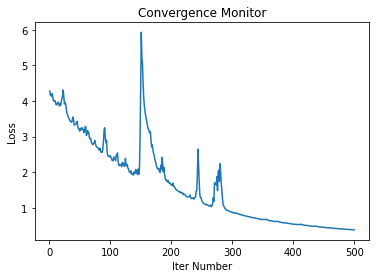

In [24]:
plt.plot(list(range(1,len(losses)+1)), losses)
plt.title('Convergence Monitor')
plt.xlabel('Iter Number')
plt.ylabel('Loss')

In [25]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)
        
        y_train.extend(list(y.cpu().detach().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Train Loss =', train_loss.item())
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

Train Loss = 0.3769224286079407


,0,1,2,3,4
0,268,1,0,1,1
1,3,289,3,1,3
2,0,0,198,1,0
3,0,1,1,296,1
4,0,0,0,2,338


In [26]:
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 0.9865056818181818 Train Precision = 0.9862133003421828 Train F1 = 0.9865079686162341


In [27]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.cpu().detach().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).cpu().detach().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 1.2461928129196167


,0,1,2,3,4
0,53,16,7,5,4
1,15,41,4,6,9
2,4,5,38,13,1
3,4,5,4,35,13
4,1,5,0,18,46


In [28]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.6051136363636364 Test Precision = 0.6118839411356858 Test F1 = 0.6058827607481851


In [29]:
# Saving the model

model_state = {'state_dict': classifier.state_dict(), 'optimizer': optimizer.state_dict()}
model_path = '/content/drive/My Drive/Q5model.pt'
torch.save(model_state, model_path)